# 5.11: Discussion - Face Detection Based on HoG Features and Binary Classifier

## Required Libraries

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from skimage.filters import sobel
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time


## Step 1: Download all the datasets and testing images

Loaded 13233 positive and 30000 negative patches.
Positive patches reshaped: (13233, 62, 47)
Negative patches reshaped: (30000, 62, 47)


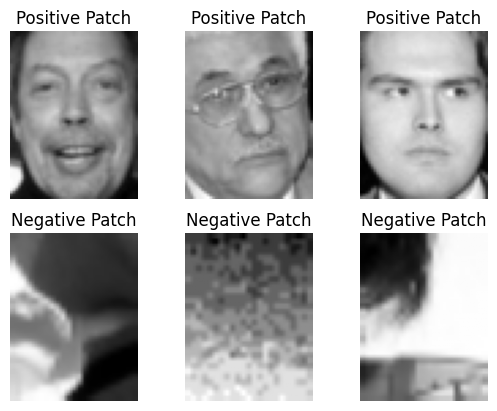

In [17]:
# Load positive and negative image patches from the previous exercise. 
# The patches have the size 62x47 pixels.
# The format of the data is numpy arrays of shape (N, P), where P is the flattened size of each patch (62*47=2914) 
# and N is the number of patches
pos_images = np.load('data/positive_patches.npy')
neg_images = np.load('data/negative_patches.npy')
print(f'Loaded {pos_images.shape[0]} positive and {neg_images.shape[0]} negative patches.')
# Reshape the patches to their original dimensions
# I am trying a different syntax that doesn't loop through each image
# but instead reshapes the entire array at once in memory, so it doesn't need to copy each image individually
# This should be faster and more memory efficient than the list comprehension.
# -1 means the number of images is calculated automatically based on the total size
# cf. https://numpy.org/doc/stable/reference/generated/numpy.reshape.html
pos_images_reshaped = pos_images.reshape((-1, 62, 47))
neg_images_reshaped = neg_images.reshape((-1, 62, 47))
# Print the shapes to verify
print(f'Positive patches reshaped: {pos_images_reshaped.shape}')
print(f'Negative patches reshaped: {neg_images_reshaped.shape}')
# Verify the reshaping by displaying a few patches
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(pos_images_reshaped[i], cmap='gray')
    plt.title('Positive Patch')
    plt.axis('off')
    
    plt.subplot(2, 3, i+4)
    plt.imshow(neg_images_reshaped[i], cmap='gray')
    plt.title('Negative Patch')
    plt.axis('off')
plt.show()

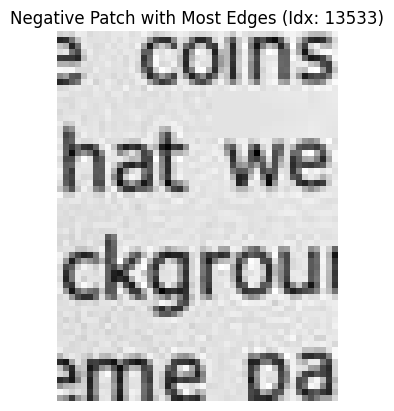

In [18]:
# I want to find "negative" images that are not just blurred background, but have some structure.
# A simple way to do this is to use edge detection (Edges = structures in images).
# I will use the Sobel filter to detect edges in the negative patches.
# The filter computes the gradient magnitude, i.e. the intensity difference for each pixel.
# The idea is that patch with the highest total aggregated intensity differences across the patch should have some structure.
edges = np.array([sobel(img).sum() for img in neg_images_reshaped])
top_index = np.argsort(edges)[-1:]
# Print the patch with highest edge response
plt.imshow(neg_images_reshaped[top_index[0]], cmap='gray')
plt.title(f'Negative Patch with Most Edges (Idx: {top_index[0]})')
plt.axis('off')
plt.show()

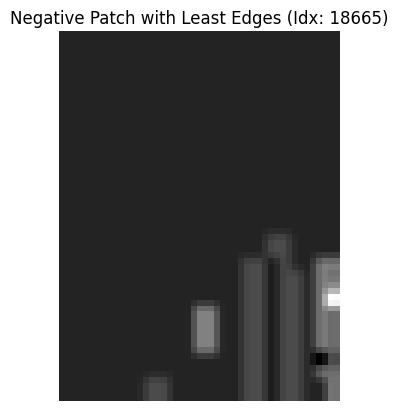

In [19]:
# It turns out a patch with text on it has the highest edge response.
# That makes sense as it is probably originally black on white with a lot of sharp edges.
# Save this patch as an example for non-face with structure.
image_example_structure_no_face = neg_images_reshaped[top_index[0]]

# Also save a patch with background only (lowest edge response)
bottom_index = np.argsort(edges)[:1]
image_example_background = neg_images_reshaped[bottom_index[0]]

plt.imshow(image_example_background, cmap='gray')
plt.title(f'Negative Patch with Least Edges (Idx: {bottom_index[0]})')
plt.axis('off')
plt.show()

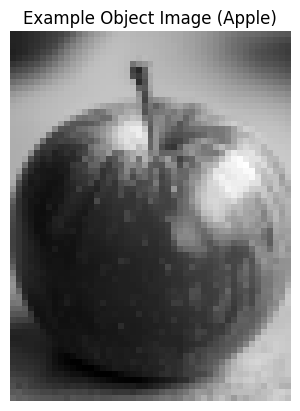

In [36]:
# It would also be nice to have an image of something that is not a face, but is an object. 
# I will reuse the apple image from the previous exercise.
image_example_object = cv2.imread('apple.jpg', cv2.IMREAD_GRAYSCALE)
# Resize to patch size
image_example_object = cv2.resize(image_example_object, (62, 62), interpolation=cv2.INTER_AREA)
image_example_object = image_example_object[:, 8:55]  # take the relevant 47 pixels horizontally  
plt.imshow(image_example_object, cmap='gray')
plt.title('Example Object Image (Apple)')
plt.axis('off')
plt.show()

## Step 2: HoG Feature

### HOG feature extraction
For each pixel, compute the intensity difference between preceding and succeeding pixel in both directions:


Gx ​= I(x+1, y)−I(x−1, y)

Gy ​= I(x, y+1)−I(x, y−1)


Then compute the magnitude and orientation of the gradient vector:


magnitude:  M(x,y)=√(Gx​2+Gy​2)

orientation:  θ(x,y)=arctan(Gy​/Gx​)

So now for every pixel in the image I know the direction in which the intensity change is the highest. So I get two numbers: the direction (orientation, = an angle), and the intensity change in this angle (magnitude).

Now I can create histograms. The bins ("x axis") are created with the orientations. 9 bins are used, representing 20 degrees each in a 360 degree circle.

The y axis is the magnitude. 

For one pixel I have only a value (the magnitude) in one bin. 

But these histograms are not created for individual pixels, but for **cells**, which are typically 8x8 pixels. 

If multiple pixels share the same orientation bin, their magnitudes are added. 

So every cell is now represented by 9 numerical values: the aggregated magnitudes for each orientation bin. These values form the basic vectors that are now combined in a number of ways. 

Typically 2x2 cells form a **block**. The block vector is contructed by simply chaining the 4 cell vectors together, so that the block vector has a dimension of 36 (4*9). 

Blocks are constructed as overlapping sliding windows, so each cell (not on the edge) is part of 4 blocks, their vector being in the 4 different positions in these blocks. This way, every cell appears in context of all neighbouring cells in the block vectors. 

The block vectors are then **normalised**. This is an important step not ensure that e.g. different contrasts in images don't impact the result. 

Typically L2 is used for normalisation (vector component divided by Euclidian length of the vector). (L1  would be vector component divided by sum of absolute vector components.) 

L2 emphasises higher magnitudes and dampens lower magnitudes (dampens noise) because values are being squared. 

Our 62x47 images with 8x8 cells results in 7x5 cells (62 div 8, 47 div 8, resp.), i.e. 35 cells in total.

With 2x2 overlapping blocks, we have 6x4 (7-1x5-1)=24 blocks.

To create the feature vector that represents the entire image, all block vectors are chained together. 

This means we have feature vectors for our images that have 24 blocks x 36 values per block (= 4 cells at 9 values each) = 864 values.  

So the final HOG feature vector for each image has a dimension of 864.

However, it could be other values than 8x8 cells and 2x2 blocks, depending on parameters used.

Dimensions of HOG feature vector for Face Patch: (864,)


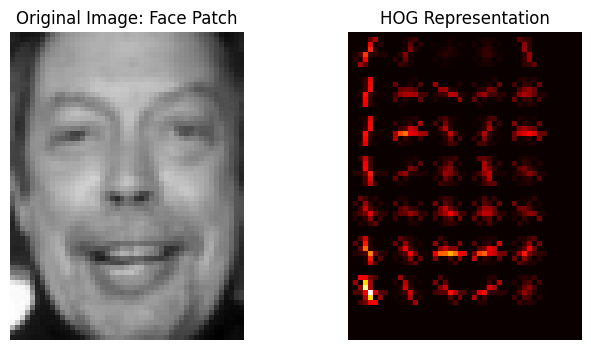

Dimensions of HOG feature vector for Structured Non-Face Patch: (864,)


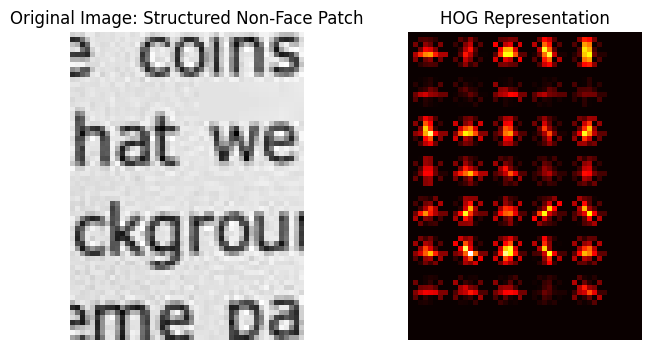

Dimensions of HOG feature vector for Background Non-Face Patch: (864,)


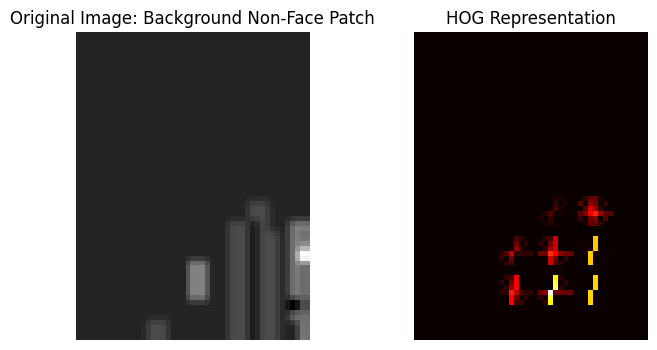

Dimensions of HOG feature vector for Object Image (Apple): (864,)


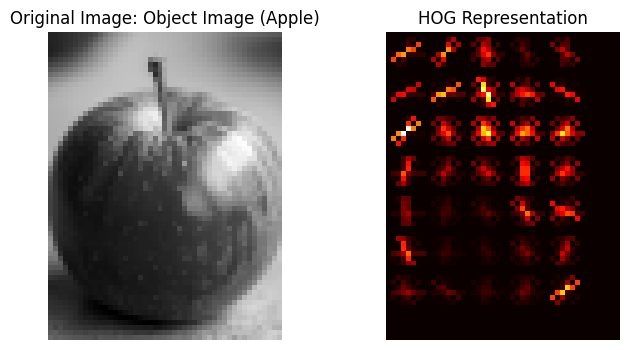

In [ ]:
# Create a list of example images
example_images = [
    ('Face Patch', pos_images_reshaped[0]),
    ('Structured Non-Face Patch', image_example_structure_no_face),
    ('Background Non-Face Patch', image_example_background),
    ('Object Image (Apple)', image_example_object)
]

# Calculate and display HOG features for each example image. Display the original image and its HOG representation side by side.
# Also print the dimensions of the HOG feature vector.
for title, img in example_images:
    hog_features, hog_image = feature.hog(img, pixels_per_cell=(8, 8),
                                          cells_per_block=(2, 2),
                                          visualize=True)
    
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original Image: {title}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap='hot')
    plt.title('HOG Representation')
    plt.axis('off')
    
    print(f'Dimensions of HOG feature vector for {title}: {hog_features.shape}')
    plt.show()


# Note that the HOG representations are created just for the purpose of visualisation. They are not used for training the classifier etc.

## Step 3: Feature Analysis

HOG features are useful because they extract the **structural information** from an image. While the basic pixels intensities represent the image, there is no direct information about shapes. HOG calculates **local edge magnitudes and orientations** in a transparent way, capturing the shape information. Objects are recognisable primarily by their shapes, and not by their pixel intensities, as these can change depending on lighting, contrast or background noise etc. 

In particular the L2 **normalisation** to a high degree removes these factors that do not define the objects in an image, and can also remove (background) noise. 

The HOG vectors are **compact** because each component ultimately represents the magnitude of an intensity gradient in a certain direction in context of neighbouring areas. They don't just represent the existence or not of something like sparse vectors, but each component gives actual measurements. 

The **spatial position** of a structure in an image is preserved in the image vector by the position of the related block vectors in the image vector. This makes it possible to detect structure combinations that exist relative to each other (at least when they have the same image coverage). 

## Step 4: Machine Learning

In [41]:
# Create test and train datasets using HOG features
def compute_hog_features(images):
    hog_features_list = []
    for img in images:
        hog_feat = feature.hog(img, pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2),
                               visualize=False)
        hog_features_list.append(hog_feat)
    return np.array(hog_features_list)
# Compute HOG features for positive and negative patches
pos_hog_features = compute_hog_features(pos_images_reshaped)
neg_hog_features = compute_hog_features(neg_images_reshaped)    
# Create labels
pos_labels = np.ones(pos_hog_features.shape[0])
neg_labels = np.zeros(neg_hog_features.shape[0])
# Combine positive and negative features and labels
X = np.vstack((pos_hog_features, neg_hog_features))
y = np.hstack((pos_labels, neg_labels))
# Create a simple train/test split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}')


Training samples: 34586, Test samples: 8647


In [ ]:
# Train a SVM classifier ("Support Vector Classifier" in scikit-learn)
# Linear SVMs try to fit a hyperplane that separates the two classes (faces vs. non-faces).
# 
# HOG features are already normalized, so a linear kernel should work well.
# The training sets are imbalanced (more negative than positive samples), so use class_weight='balanced' to compensate for that.
svc = SVC(
    kernel='linear',
    class_weight='balanced'
)
svc.fit(X_train, y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'linear'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [ ]:
# Also try an SVC with RBF kernel () to compare with linear kernel
# RBF kernels allow the separating hyperplane to be non-linear
svc_rbf = SVC(
    kernel='rbf',
    class_weight='balanced'
)
svc_rbf.fit(X_train, y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [ ]:
# As an ensemble method, I will use AdaBoost with decision trees as base classifiers.
# Decision trees (in particular stumps) are weak classifiers that can be boosted effectively.
# Weak learners are just a bit better than random guessing.
# Adaboost will combine multiple weak classifiers to create a strong classifier.
# Basically it weighs the error of wrongly classified samples more heavily in the next iteration,
# so that the next weak classifier focuses on the hard samples.
# So increasingly the model focusses on the hard-to-classify samples.
base_classifier = DecisionTreeClassifier(max_depth=1)  
# Use 50 estimators for boosting, i.e. 50 weak classifiers will be combined.
# Learning rate controls the contribution of each weak classifier.
adaboost_classifier = AdaBoostClassifier(
    estimator=base_classifier,
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)
adaboost_classifier.fit(X_train, y_train)
# Note that training AdaBoost is much slower than SVC as it needs to train multiple weak classifiers sequentially.

,"estimator estimator: object, default=NoneThe base estimator from which the boosted ensemble is built.Support for sample weighting is required, as well as proper``classes_`` and ``n_classes_`` attributes. If ``None``, thenthe base estimator is :class:`~sklearn.tree.DecisionTreeClassifier`initialized with `max_depth=1`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",DecisionTreeC...r(max_depth=1)
,"n_estimators n_estimators: int, default=50The maximum number of estimators at which boosting is terminated.In case of perfect fit, the learning procedure is stopped early.Values must be in the range `[1, inf)`.",50
,"learning_rate learning_rate: float, default=1.0Weight applied to each classifier at each boosting iteration. A higherlearning rate increases the contribution of each classifier. There isa trade-off between the `learning_rate` and `n_estimators` parameters.Values must be in the range `(0.0, inf)`.",1.0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random seed given at each `estimator` at eachboosting iteration.Thus, it is only used when `estimator` exposes a `random_state`.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",1
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None


In [ ]:
# As another ensemble I will use Random Forests.
# Random Forests create multiple decision trees on random subsets of the data and features.
# Each tree votes for a class, and the class with the most votes is chosen as the final prediction.
# This reduces overfitting and improves generalization.
random_forest = RandomForestClassifier(
    n_estimators=100,       # number of trees
    max_depth=None,         # None = nodes expanded until pure or min_samples_split
    max_features='sqrt',    # number of features to consider at each split (square root of total features is common, so here 29 features = sqrt(864))
    class_weight='balanced',# handles class imbalance
    n_jobs=-1,              # use all CPU cores
    random_state=42
)
random_forest.fit(X_train, y_train)

# Note that training RF was faster even than SVC.

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

## Step 5: Performance Analysis

In [56]:
models = {
    'SVM': svc,
    'SVM (RBF Kernel)': svc_rbf,
    'AdaBoost': adaboost_classifier,
    'Random Forest': random_forest
}

# Evaluate each model on the test set
for model_name, model in models.items():
    print(f'--- Evaluating {model_name} ---')
    start = time.time()
    y_pred = model.predict(X_test)
    end = time.time()
    print(f'Prediction time: {end - start:.4f} seconds')
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))    
# It seems that all three models perform quite well on the test set.
# SVM has the highest precision and recall, followed by Random Forest and AdaBoost.
# However, the differences are not very large.
# In practice, the choice of model may depend on other factors such as training time, interpret

--- Evaluating SVM ---
Prediction time: 1.1113 seconds
[[5902   40]
 [  49 2656]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5942
         1.0       0.99      0.98      0.98      2705

    accuracy                           0.99      8647
   macro avg       0.99      0.99      0.99      8647
weighted avg       0.99      0.99      0.99      8647

--- Evaluating SVM (RBF Kernel) ---
Prediction time: 5.3333 seconds
[[5939    3]
 [  26 2679]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5942
         1.0       1.00      0.99      0.99      2705

    accuracy                           1.00      8647
   macro avg       1.00      0.99      1.00      8647
weighted avg       1.00      1.00      1.00      8647

--- Evaluating AdaBoost ---
Prediction time: 0.2115 seconds
[[5874   68]
 [  83 2622]]
              precision    recall  f1-score   support

         0.0       0.99    

### Analysis
All models perform surprisingly well with accuracies of 98%+.

The best model with 100% accuracy is the SVC with RBF kernel. 

The fastest model for inference was the Random Forest model (0.0428s for the test set), followed by AdaBoost (0.2115s). The SVC models were significantly slower with 1.1113s for the linear kernel, and 5.3333s for the rbf-kernel.

This allows us to choose the best model depending on our needs. If accuracy is prioritised, the SVC-RBF model is the best option. If speed is prioritised, a RF model may be the better choice as it still performs very well but is faster by 2 orders of magnitude. 

Notably the training of the forest models is noticably slower than that of the linear classifiers. 

